In [ ]:
import numpy as np
import numpy.linalg
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics, sklearn.decomposition
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction and Matrix Factorization

## Objectives:
1. Apply SVD (complete) and Reduced SVD method to Bars Dataset and evaluate also data with noise.
2. Reconstruct the data with different reduction (2, 5, 10, 16 basis functions).
3. Try the NNMF method similarly.
4. Take the Mnist dataset and apply SVD recomposition and visualize it in vector space. Coloring take from Labels
5. Try to reconstruct the reduced data and visualize it.
6. Use PCA and t-SNE for further visualization of the Mnist dataset

---


## Exercise 1: Bars Dataset - SVD Analysis

**Task:** Apply SVD decomposition to the bars dataset.

- Apply complete SVD decomposition to noisy and clean data
- Visualize the singular values and compare clean vs noisy data
- Analyze the differences in singular value patterns


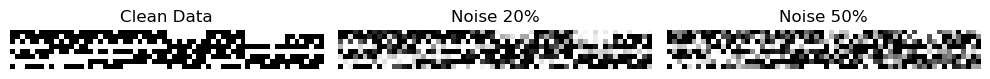

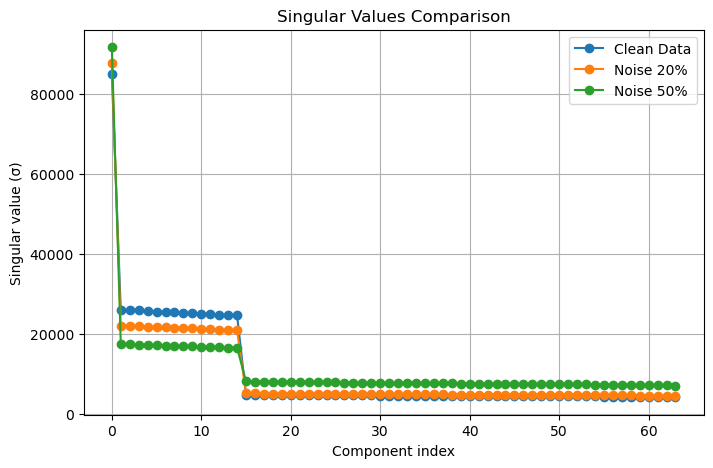

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Načtení datasetů ---
bars_clean = np.loadtxt("datasets/ml_05/bars.csv", delimiter=",")
bars_n20 = np.loadtxt("datasets/ml_05/bars_noise20.csv", delimiter=",")
bars_n50 = np.loadtxt("datasets/ml_05/bars_noise50.csv", delimiter=",")

# --- SVD rozklad ---
U_c, S_c, Vt_c = np.linalg.svd(bars_clean, full_matrices=False)
U_20, S_20, Vt_20 = np.linalg.svd(bars_n20, full_matrices=False)
U_50, S_50, Vt_50 = np.linalg.svd(bars_n50, full_matrices=False)

# --- Funkce pro normalizaci a vykreslení jednoho reprezentativního obrázku ---
def show_one_image(data, title, img_size=8, idx=0):
    img = data[idx * img_size:(idx + 1) * img_size, :]
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

# --- Vizualizace 3 datasetů ---
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
datasets = [
    ("Clean Data", bars_clean),
    ("Noise 20%", bars_n20),
    ("Noise 50%", bars_n50)
]

for ax, (title, data) in zip(axs, datasets):
    plt.sca(ax)
    show_one_image(data, title, img_size=8)

plt.tight_layout()
plt.show()

# --- Porovnání singulárních hodnot ---
plt.figure(figsize=(8, 5))
plt.plot(S_c, 'o-', label='Clean Data')
plt.plot(S_20, 'o-', label='Noise 20%')
plt.plot(S_50, 'o-', label='Noise 50%')
plt.title("Singular Values Comparison")
plt.xlabel("Component index")
plt.ylabel("Singular value (σ)")
plt.legend()
plt.grid(True)
plt.show()



## Exercise 2: Data Reconstruction with Different Reduction Levels

**Task:** Reconstruct the Bars Dataset using different numbers of basis functions.

- Test reconstruction with 2, 5, 10, and 16 basis functions
- Calculate reconstruction error (MSE) for each reduction level
- Visualize original vs reconstructed data
- Plot reconstruction error vs number of components


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


# Počty komponent, které chceme vyzkoušet
components = [2, 5, 10, 16]
errors = []

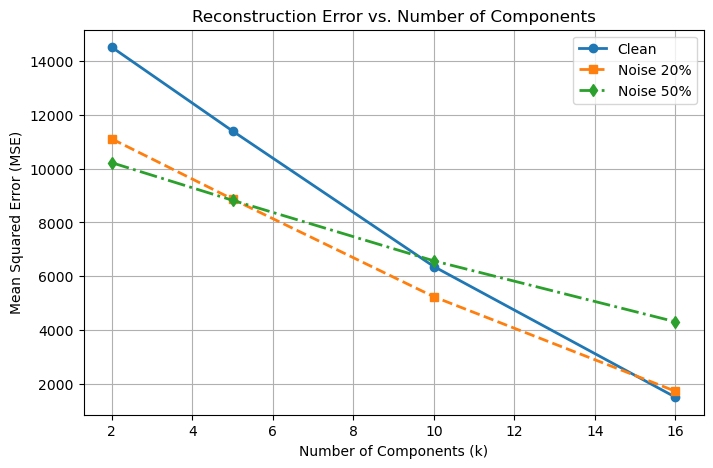


📊 Reconstruction Errors:
 k |   Clean   |  Noise 20%  |  Noise 50%
 --|-----------|-------------|------------
 2 |  14514.72 |    11105.14 |   10219.72
 5 |  11398.09 |     8865.74 |    8822.38
10 |   6358.79 |     5235.19 |    6570.05
16 |   1499.81 |     1721.78 |    4304.52


In [18]:
# --- Funkce pro výpočet MSE chyb pro různé počty komponent ---
def reconstruction_errors(U, S, Vt, original, components):
    errors = []
    for k in components:
        A_k = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
        mse = mean_squared_error(original, A_k)
        errors.append(mse)
    return errors

# --- Počty komponent ---
components = [2, 5, 10, 16]

# --- Výpočet chyb pro všechny datasety ---
datasets = [
    ("Clean", bars_clean, U_c, S_c, Vt_c),
    ("Noise 20%", bars_n20, U_20, S_20, Vt_20),
    ("Noise 50%", bars_n50, U_50, S_50, Vt_50)
]

all_errors = {}

for name, data, U, S, Vt in datasets:
    all_errors[name] = reconstruction_errors(U, S, Vt, data, components)

# --- Srovnávací graf všech datasetů ---
plt.figure(figsize=(8,5))
plt.plot(components, all_errors["Clean"], 'o-', label="Clean", linewidth=2)
plt.plot(components, all_errors["Noise 20%"], 's--', label="Noise 20%", linewidth=2)
plt.plot(components, all_errors["Noise 50%"], 'd-.', label="Noise 50%", linewidth=2)
plt.title("Reconstruction Error vs. Number of Components")
plt.xlabel("Number of Components (k)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# --- Výpis výsledků do konzole ---
print("\n📊 Reconstruction Errors:")
print(" k |   Clean   |  Noise 20%  |  Noise 50%")
print(" --|-----------|-------------|------------")
for i, k in enumerate(components):
    print(f"{k:2} | {all_errors['Clean'][i]:9.2f} | {all_errors['Noise 20%'][i]:11.2f} | {all_errors['Noise 50%'][i]:10.2f}")


## Exercise 3: Non-Negative Matrix Factorization (NNMF)

**Task:** Apply NNMF to the Bars Dataset and compare with SVD results.

- Implement NNMF decomposition for the Bars Dataset
- Apply NNMF with different numbers of components (2, 5, 10, 16)
- Compare NNMF reconstruction quality with SVD
- Visualize NNMF components and reconstructions
- Analyze reconstruction errors for both methods


In [19]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- NNMF vyžaduje pouze nezáporné hodnoty ---
bars_clean_pos = np.maximum(bars_clean, 0)
bars_n20_pos   = np.maximum(bars_n20, 0)
bars_n50_pos   = np.maximum(bars_n50, 0)

# --- Počet komponent ---
components = [2, 5, 10, 16]

# --- Datové sady a jejich SVD rozklady ---
datasets = [
    ("Clean", bars_clean_pos, bars_clean, U_c, S_c, Vt_c),
    ("Noise 20%", bars_n20_pos, bars_n20, U_20, S_20, Vt_20),
    ("Noise 50%", bars_n50_pos, bars_n50, U_50, S_50, Vt_50)
]

# --- Uchování chyb ---
errors_svd = {}
errors_nmf = {}

for name, X_pos, X_orig, U, S, Vt in datasets:
    svd_list = []
    nmf_list = []

    # --- SVD rekonstrukce ---
    for k in components:
        A_svd = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
        svd_list.append(mean_squared_error(X_orig, A_svd))

    # --- NNMF rekonstrukce ---
    for k in components:
        model = NMF(n_components=k, init='nndsvda', random_state=42, max_iter=3000)
        W = model.fit_transform(X_pos)
        H = model.components_
        A_nmf = W @ H
        nmf_list.append(mean_squared_error(X_orig, A_nmf))

    errors_svd[name] = svd_list
    errors_nmf[name] = nmf_list

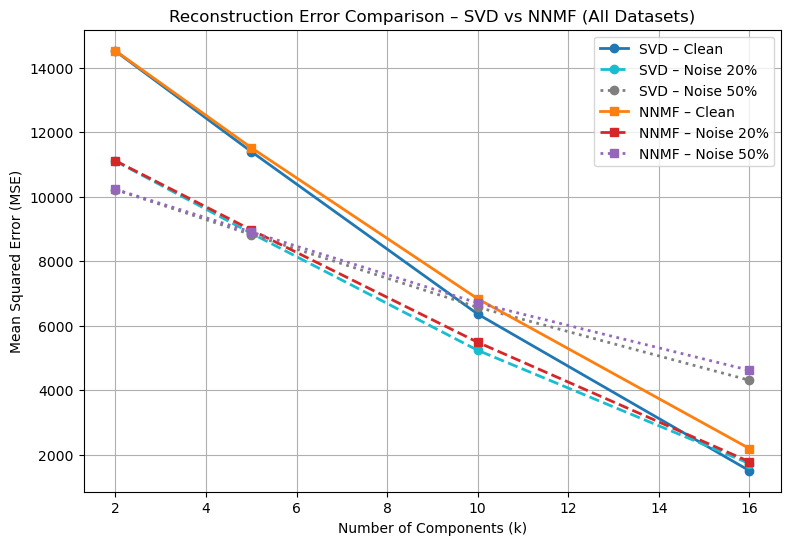

📊 Reconstruction MSE Comparison (SVD vs NNMF)
k | Dataset       |     SVD      |     NNMF
--|----------------|--------------|--------------
 2 | Clean         |  14514.725 |  14525.579
 5 | Clean         |  11398.094 |  11518.611
10 | Clean         |   6358.792 |   6832.870
16 | Clean         |   1499.812 |   2186.939
----------------------------------------------
 2 | Noise 20%     |  11105.136 |  11114.229
 5 | Noise 20%     |   8865.744 |   8968.057
10 | Noise 20%     |   5235.193 |   5483.996
16 | Noise 20%     |   1721.783 |   1777.774
----------------------------------------------
 2 | Noise 50%     |  10219.721 |  10229.204
 5 | Noise 50%     |   8822.376 |   8904.431
10 | Noise 50%     |   6570.050 |   6701.826
16 | Noise 50%     |   4304.522 |   4613.911
----------------------------------------------


In [20]:
# --- Grafické porovnání ---
plt.figure(figsize=(9,6))

# SVD
plt.plot(components, errors_svd["Clean"], 'o-', color='tab:blue', label="SVD – Clean", linewidth=2)
plt.plot(components, errors_svd["Noise 20%"], 'o--', color='tab:cyan', label="SVD – Noise 20%", linewidth=2)
plt.plot(components, errors_svd["Noise 50%"], 'o:', color='tab:gray', label="SVD – Noise 50%", linewidth=2)

# NNMF
plt.plot(components, errors_nmf["Clean"], 's-', color='tab:orange', label="NNMF – Clean", linewidth=2)
plt.plot(components, errors_nmf["Noise 20%"], 's--', color='tab:red', label="NNMF – Noise 20%", linewidth=2)
plt.plot(components, errors_nmf["Noise 50%"], 's:', color='tab:purple', label="NNMF – Noise 50%", linewidth=2)

plt.title("Reconstruction Error Comparison – SVD vs NNMF (All Datasets)")
plt.xlabel("Number of Components (k)")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.legend()
plt.show()

# --- Výpis tabulky s výsledky ---
print("📊 Reconstruction MSE Comparison (SVD vs NNMF)")
print("k | Dataset       |     SVD      |     NNMF")
print("--|----------------|--------------|--------------")
for name in errors_svd.keys():
    for k, e_svd, e_nmf in zip(components, errors_svd[name], errors_nmf[name]):
        print(f"{k:2} | {name:<13} | {e_svd:10.3f} | {e_nmf:10.3f}")
    print("-" * 46)


## Exercise 4: MNIST Dataset - SVD Analysis and Visualization

**Task:** Apply SVD decomposition to MNIST dataset and visualize in vector space.

- Apply SVD decomposition to MNIST data
- Analyze singular values and cumulative explained variance
- Visualize MNIST data in 2D using first two SVD components
- Color points by digit labels
- Try different component combinations (e.g., components 2 and 3)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Načtení lokálních dat
X = np.loadtxt("datasets/ml_05/mnist.csv", delimiter=",")
y = np.loadtxt("datasets/ml_05/mnist_labels.csv", delimiter=",").astype(int)

print("Data načtena:", X.shape, "Labels:", y.shape)

Data načtena: (60000, 784) Labels: (60000,)


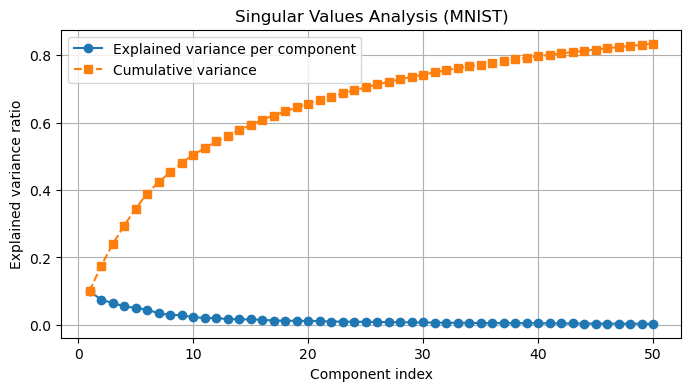

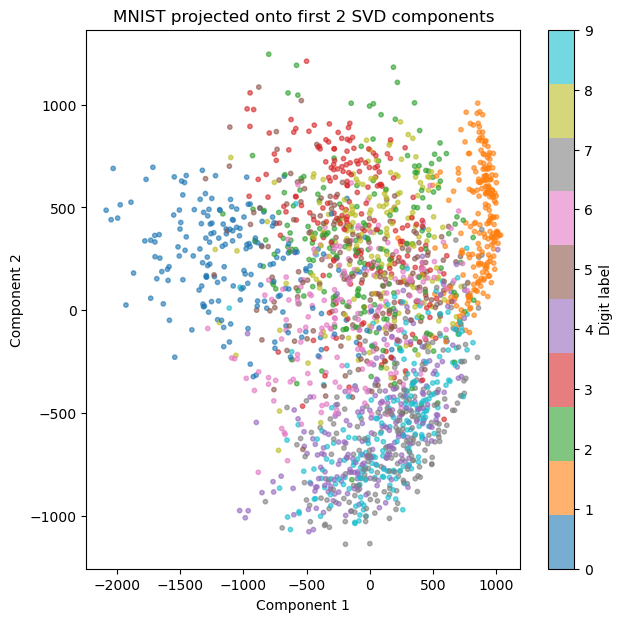

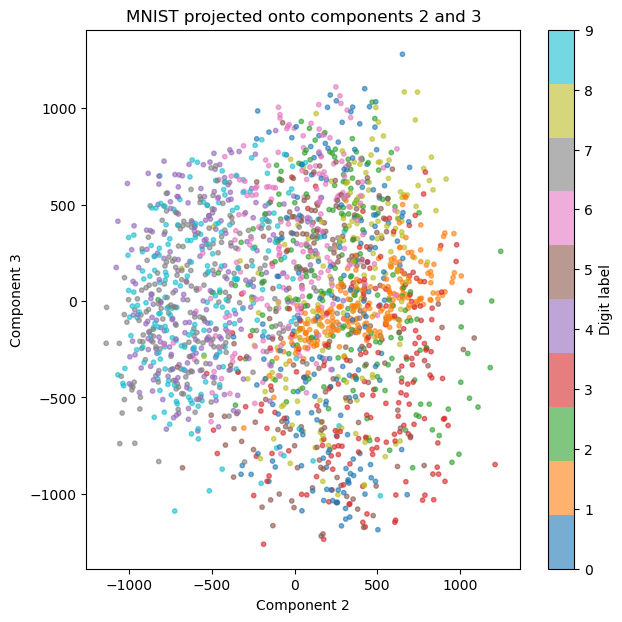

In [23]:
# Pro rychlost (vezmeme jen 2000 vzorků)
X = X[:2000]
y = y[:2000]

# Normalizace 
X_scaled = StandardScaler(with_std=False).fit_transform(X)

# SVD rozklad 
U, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)

# Analýza singulárních hodnot 
explained_variance = (S ** 2) / np.sum(S ** 2)
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, 51), explained_variance[:50], 'o-', label="Explained variance per component")
plt.plot(np.arange(1, 51), cumulative_variance[:50], 's--', label="Cumulative variance")
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio")
plt.title("Singular Values Analysis (MNIST)")
plt.legend()
plt.grid(True)
plt.show()

# Vizualizace v prostoru prvních 2 komponent
Z_2D = U[:, :2] @ np.diag(S[:2])

plt.figure(figsize=(7,7))
scatter = plt.scatter(Z_2D[:, 0], Z_2D[:, 1], c=y, cmap='tab10', s=10, alpha=0.6)
plt.title("MNIST projected onto first 2 SVD components")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label="Digit label")
plt.show()

# Vizualizace v prostoru komponent (2,3) 
Z_23 = U[:, 1:3] @ np.diag(S[1:3])

plt.figure(figsize=(7,7))
scatter = plt.scatter(Z_23[:, 0], Z_23[:, 1], c=y, cmap='tab10', s=10, alpha=0.6)
plt.title("MNIST projected onto components 2 and 3")
plt.xlabel("Component 2")
plt.ylabel("Component 3")
plt.colorbar(scatter, label="Digit label")
plt.show()


## Exercise 5: PCA and t-SNE Visualization of MNIST Dataset

**Task:** Apply PCA and t-SNE for dimensionality reduction and visualization of MNIST.

- Apply PCA to MNIST dataset
- Visualize MNIST data in 2D PCA space
- Apply t-SNE for non-linear dimensionality reduction
- Compare SVD, PCA, and t-SNE visualizations
- Color all visualizations by digit labels



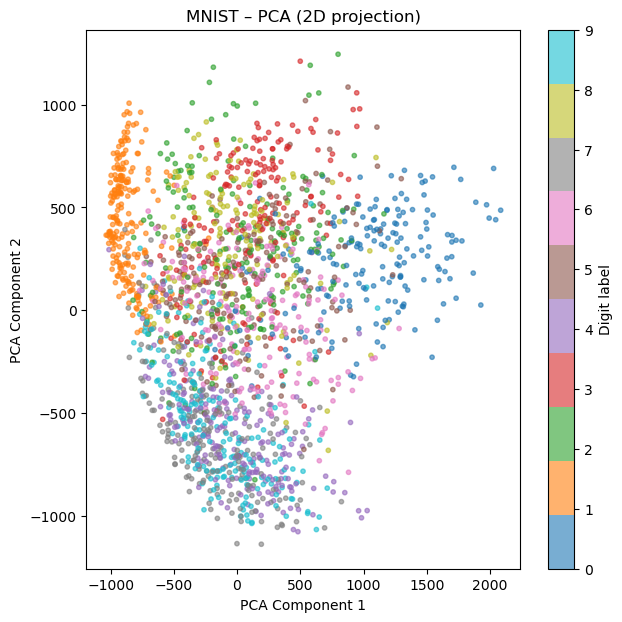

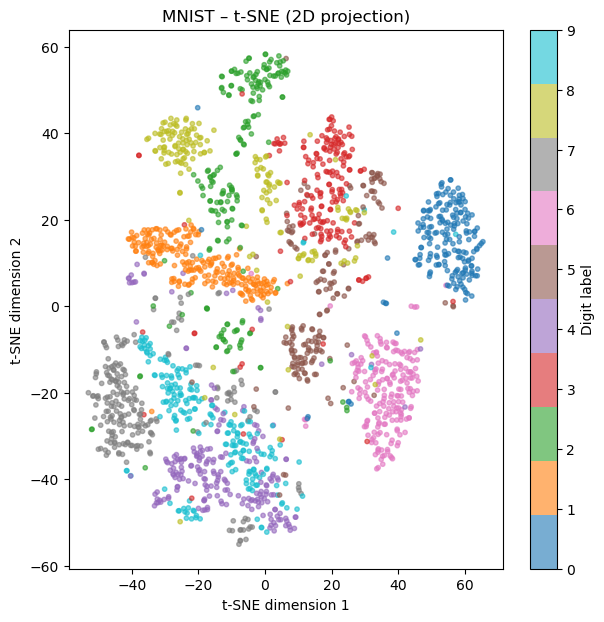

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(7,7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10, alpha=0.6)
plt.title("MNIST – PCA (2D projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Digit label")
plt.show()


#  t-SNE 
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    init='pca'  
)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(7,7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', s=10, alpha=0.6)
plt.title("MNIST – t-SNE (2D projection)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.colorbar(scatter, label="Digit label")
plt.show()

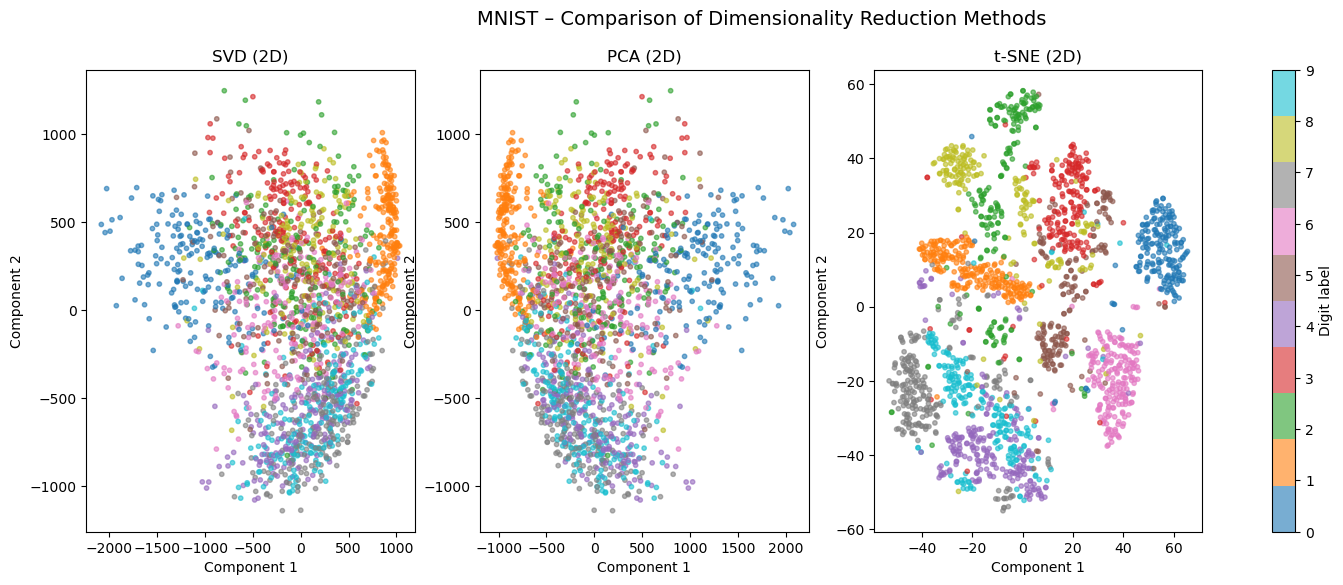

In [24]:
# Porovnání SVD × PCA × t-SNE v jednom grafu
Z_svd = U[:, :2] @ np.diag(S[:2])  # z Exercise 4

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["SVD (2D)", "PCA (2D)", "t-SNE (2D)"]
datasets = [Z_svd, X_pca, X_tsne]

for ax, title, data in zip(axs, titles, datasets):
    scatter = ax.scatter(data[:, 0], data[:, 1], c=y, cmap='tab10', s=10, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

fig.suptitle("MNIST – Comparison of Dimensionality Reduction Methods", fontsize=14)
fig.colorbar(scatter, ax=axs, orientation='vertical', label="Digit label")
plt.show()